C:\Users\lenovo\AppData\Local\Temp\ipykernel_13348\2965408395.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  * tau) / float(sigma * np.sqrt(tau))


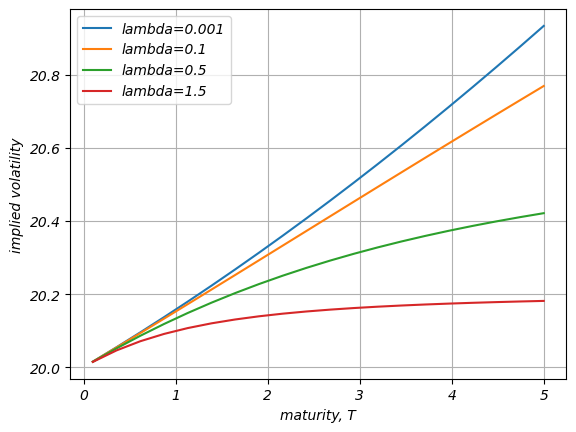

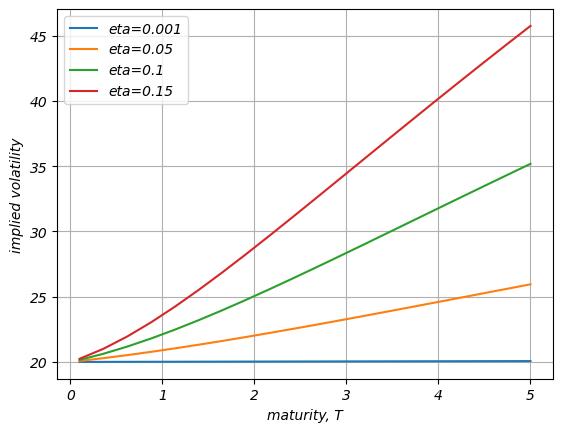

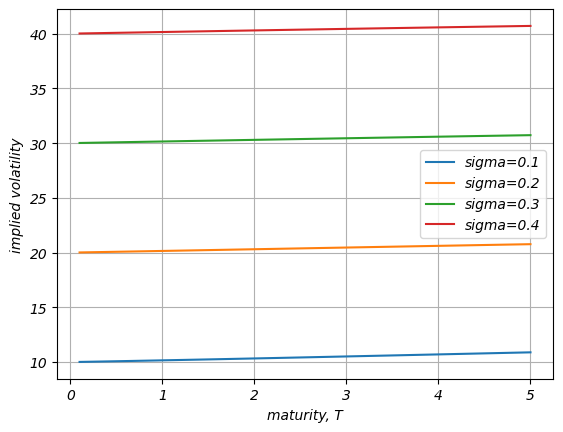

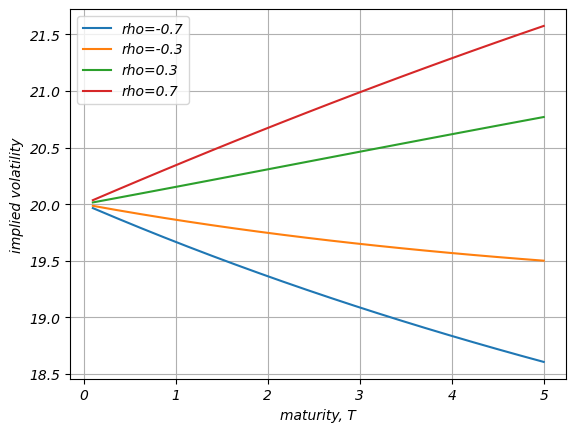

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.stats as stats
import enum
import scipy.optimize as optimize

# set i= imaginary number
i = 1j

# time-step needed for differentiation
dt = 0.0001


# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0


# Black-Scholes Call option price
def BS_Call_Option_Price(CP, S_0, K, sigma, tau, r):
    if K is list:
        K = np.array(K).reshape([len(K), 1])
    d1 = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma, 2.0))
          * tau) / float(sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    if CP == OptionType.CALL:
        value = stats.norm.cdf(d1) * S_0 - stats.norm.cdf(d2) * K * np.exp(-r * tau)
    elif CP == OptionType.PUT:
        value = stats.norm.cdf(-d2) * K * np.exp(-r * tau) - stats.norm.cdf(-d1) * S_0
    return value


# Implied volatility method
def ImpliedVolatilityBlack76(CP, frwdMarketPrice, K, T, frwdStock):
    func = lambda sigma: np.power(BS_Call_Option_Price(CP, frwdStock, K, sigma, T, 0.0) - frwdMarketPrice, 1.0)
    impliedVol = optimize.newton(func, 0.2, tol=1e-9)
    # impliedVol = optimize.brent(func, brack= (0.05, 2))
    return impliedVol


def BSHWVolatility(T, eta, sigma, rho, lambd):
    Br = lambda t, T: 1 / lambd * (np.exp(-lambd * (T - t)) - 1.0)
    sigmaF = lambda t: np.sqrt(sigma * sigma + eta * eta * Br(t, T) * Br(t, T) \
                               - 2.0 * rho * sigma * eta * Br(t, T))
    zGrid = np.linspace(0.0, T, 2500)
    sigmaC = np.sqrt(1 / T * np.trapz(sigmaF(zGrid) * sigmaF(zGrid), zGrid))
    return sigmaC


def BSHWOptionPrice(CP, S0, K, P0T, T, eta, sigma, rho, lambd):
    frwdS0 = S0 / P0T
    vol = BSHWVolatility(T, eta, sigma, rho, lambd)
    # As we deal with the forward prices we evaluate Black's 76 prices
    r = 0.0
    BlackPrice = BS_Call_Option_Price(CP, frwdS0, K, vol, T, r)
    return P0T * BlackPrice


def mainCalculation():
    CP = OptionType.CALL

    # HW model settings
    lambd = 0.1
    eta = 0.01
    sigma = 0.2
    rho = 0.3
    S0 = 100

    # Strike equals stock value, thus ATM
    K = [100]
    K = np.array(K).reshape([len(K), 1])

    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.05 * T)

    # Maturitires at which we compute implied volatility
    TMat = np.linspace(0.1, 5.0, 20)

    # Effect of lambda
    plt.figure(2)
    plt.grid()
    plt.xlabel('maturity, T')
    plt.ylabel('implied volatility')
    lambdV = [0.001, 0.1, 0.5, 1.5]
    legend = []
    for lambdaTemp in lambdV:
        IV = np.zeros([len(TMat), 1])
        for idx in range(0, len(TMat)):
            T = TMat[idx]
            val = BSHWOptionPrice(CP, S0, K, P0T(T), T, eta, sigma, rho, lambdaTemp)
            frwdStock = S0 / P0T(T)
            valFrwd = val / P0T(T)
            IV[idx] = ImpliedVolatilityBlack76(CP, valFrwd, K, T, frwdStock)
        plt.plot(TMat, IV * 100.0)
        legend.append('lambda={0}'.format(lambdaTemp))
    plt.legend(legend)

    # Effect of eta
    plt.figure(3)
    plt.grid()
    plt.xlabel('maturity, T')
    plt.ylabel('implied volatility')
    etaV = [0.001, 0.05, 0.1, 0.15]
    legend = []
    for etaTemp in etaV:
        IV = np.zeros([len(TMat), 1])
        for idx in range(0, len(TMat)):
            T = TMat[idx]
            val = BSHWOptionPrice(CP, S0, K, P0T(T), T, etaTemp, sigma, rho, lambd)
            frwdStock = S0 / P0T(T)
            valFrwd = val / P0T(T)
            IV[idx] = ImpliedVolatilityBlack76(CP, valFrwd, K, T, frwdStock)
        plt.plot(TMat, IV * 100.0)
        legend.append('eta={0}'.format(etaTemp))
    plt.legend(legend)

    # Effect of sigma
    plt.figure(4)
    plt.grid()
    plt.xlabel('maturity, T')
    plt.ylabel('implied volatility')
    sigmaV = [0.1, 0.2, 0.3, 0.4]
    legend = []
    for sigmaTemp in sigmaV:
        IV = np.zeros([len(TMat), 1])
        for idx in range(0, len(TMat)):
            T = TMat[idx]
            val = BSHWOptionPrice(CP, S0, K, P0T(T), T, eta, sigmaTemp, rho, lambd)
            frwdStock = S0 / P0T(T)
            valFrwd = val / P0T(T)
            IV[idx] = ImpliedVolatilityBlack76(CP, valFrwd, K, T, frwdStock)
        plt.plot(TMat, IV * 100.0)
        legend.append('sigma={0}'.format(sigmaTemp))
    plt.legend(legend)

    # Effect of rho
    plt.figure(5)
    plt.grid()
    plt.xlabel('maturity, T')
    plt.ylabel('implied volatility')
    rhoV = [-0.7, -0.3, 0.3, 0.7]
    legend = []
    for rhoTemp in rhoV:
        IV = np.zeros([len(TMat), 1])
        for idx in range(0, len(TMat)):
            T = TMat[idx]
            val = BSHWOptionPrice(CP, S0, K, P0T(T), T, eta, sigma, rhoTemp, lambd)
            frwdStock = S0 / P0T(T)
            valFrwd = val / P0T(T)
            IV[idx] = ImpliedVolatilityBlack76(CP, valFrwd, K, T, frwdStock)
        plt.plot(TMat, IV * 100.0)
        legend.append('rho={0}'.format(rhoTemp))
    plt.legend(legend)


if __name__ == "__main__":
    mainCalculation()